Посмотрим на результат добавления признаков кластера и коэффициентов без данных о детской смертности.

> TODO - убрать этот файл

In [1]:
import sys
# Добавим папку с корнем проекта в список системных директорий, чтобы Python видел путь к папкам utils и classes
sys.path.append('..')

In [2]:
from IPython.display import Markdown
import time
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import (
    BaggingRegressor, 
    AdaBoostRegressor,
    StackingRegressor,
)

from utils.constants import (
    F, 
    RANDOM_STATE,
)
from utils.helpers import get_exec_time
from utils.graphics import (
    display_corellation_by_target,
)
from utils.display_content import (
    display_fields_correlation,
)
from utils.prepare_data import (
    get_location_codes,
    get_location_time_series,
    get_location_by_code,
    get_train_test_data,
    get_data_with_smoothing_target_feature,
    get_integration_order,
    get_predictors,
    get_train_test_split,
    get_location_data,
    get_formatted_time_series,
)
from classes.LocationCluster import LocationCluster
from classes.LocationCoef import LocationCoef


%matplotlib inline

from warnings import simplefilter
simplefilter('ignore')

In [3]:
# Загрузим таблицу
data_source = pd.read_csv(
    '../data/cumulative_life_expectancy_prepared.csv'
)

data_source.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,PositiveCoef,NegativeCoef,ImmunizationMean,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,1.11,7.66,563.733796,16194869.0,5.027188,1,0.839586,0.837126,28.000000,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,2.05,13.35,533.586202,16747208.0,5.092250,1,0.839586,0.837126,43.333333,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,1.31,11.54,882.147847,17327699.0,5.157312,1,0.839586,0.837126,42.666667,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,1.47,14.55,992.698979,17943712.0,5.222375,1,0.839586,0.837126,37.000000,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,1.69,21.36,1266.210864,18600423.0,5.287437,1,0.839586,0.837126,36.000000,52.36


In [4]:
data = data_source.drop(columns=['ClusterKMeans', 'PositiveCoef', 'NegativeCoef', 'ImmunizationMean'])
data.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,BmiTeenagerOverweight2,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,0.99,27.56,41.14,2.74,1.11,7.66,563.733796,16194869.0,5.027188,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,1.07,28.99,42.25,5.97,2.05,13.35,533.586202,16747208.0,5.092250,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,1.14,30.42,43.38,4.19,1.31,11.54,882.147847,17327699.0,5.157312,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,1.22,31.86,44.36,4.26,1.47,14.55,992.698979,17943712.0,5.222375,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,1.31,33.29,45.35,5.66,1.69,21.36,1266.210864,18600423.0,5.287437,52.36


In [5]:
train_data, test_data = get_train_test_data(data)

In [6]:
test_data[F.Period.value].unique()

array([2018, 2019, 2020], dtype=int64)

Добавим признак с кластером

In [7]:
cluster_creater = LocationCluster(2)
cluster_creater.fit(train_data)

train_data = cluster_creater.transform(train_data)
test_data = cluster_creater.transform(test_data)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,27.56,41.14,2.74,1.11,7.66,563.733796,16194869.0,5.027188,1,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,28.99,42.25,5.97,2.05,13.35,533.586202,16747208.0,5.092250,1,50.06


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,LifeExpectancy
0,AFR,Africa,AGO,Angola,2018,25.83,0.00938,0.233096,24.0,0.013602,...,51.12,56.59,5.36,1.10,35.75,2538.591391,31297155.0,6.377063,1,62.27
1,AFR,Africa,AGO,Angola,2019,25.79,0.00920,0.227687,24.6,0.013479,...,51.39,56.88,5.51,1.12,29.33,2189.855714,32375632.0,6.488062,1,62.49


Добавим признаки с коэффициентами.

In [8]:
columns_to_exclude = [
    F.Period.value,
    F.Population.value, 
    F.AlcoholСonsumption.value,
    F.BmiAdultOverweight25.value,
    F.BmiAdultOverweight30.value,
    F.BmiChildOverweight1.value,
    F.BmiTeenagerOverweight1.value,
    F.BmiChildOverweight2.value,
    F.BmiTeenagerOverweight2.value,
    F.AdultNcdMortality061.value,
    F.AdultNcdMortality080.value,#
    F.AdultNcdMortalitySum.value,
    F.AdultNcdMortality110.value,
    F.AdultNcdMortality117.value,
    #F.ChildUnder5Mortality15.value,
    #F.ChildUnder5Mortality16.value,
    #F.ChildUnder5Mortality10.value,
    #F.ChildUnder5Mortality17.value,
]

coefs_creater = LocationCoef(columns_to_exclude)
coefs_creater.fit(train_data)

train_data = coefs_creater.transform(train_data)
test_data = coefs_creater.transform(test_data)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,PositiveCoef,NegativeCoef,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,2.74,1.11,7.66,563.733796,16194869.0,5.027188,1,0.852888,0.877377,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,5.97,2.05,13.35,533.586202,16747208.0,5.092250,1,0.852888,0.877377,50.06


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,PositiveCoef,NegativeCoef,LifeExpectancy
0,AFR,Africa,AGO,Angola,2018,25.83,0.00938,0.233096,24.0,0.013602,...,5.36,1.10,35.75,2538.591391,31297155.0,6.377063,1,0.852888,0.877377,62.27
1,AFR,Africa,AGO,Angola,2019,25.79,0.00920,0.227687,24.6,0.013479,...,5.51,1.12,29.33,2189.855714,32375632.0,6.488062,1,0.852888,0.877377,62.49


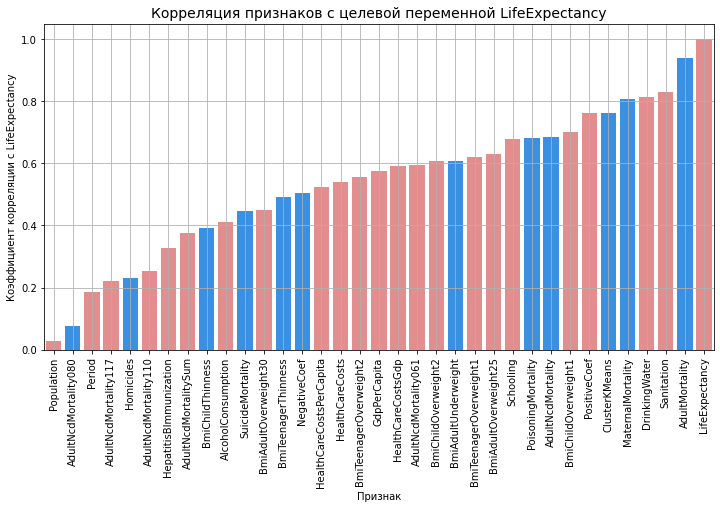

In [9]:
display_corellation_by_target(train_data)